In [100]:
import torch
from torch import nn
import circuits as ckt
import learn as lrn

In [101]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': -10, 'v': None, 'attr': 1}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': None})]


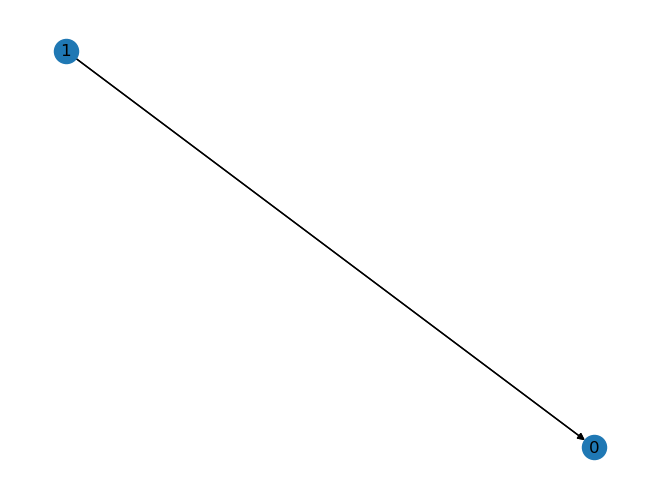

In [102]:
vr = ckt.Circuit()

v_source = vr.add_element(kind=ckt.Kinds.IVS)
r1 = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, r1.high)
v_source.connect(v_source.low, r1.low)
# Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# # Case 2 one resisance unknown
v_source.attr = 1
v_source.i = -10

# v_source = vr.add_element(kind=ckt.Kinds.IVS)
# r1 = vr.add_element(kind=ckt.Kinds.R)
# r2 = vr.add_element(kind=ckt.Kinds.R)
# v_source.connect(v_source.high, r1.high)
# r1.connect(r1.low, r2.high)
# v_source.connect(v_source.low, r2.low)
# # Case 1 all resistances known
# v_source.attr = 1
# r1.attr = 1e6
# r2.attr = 1e6
# # Case 2 one resisance unknown
# v_source.attr = 1
# r1.attr = 1e6
# r2.v = 0.5

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [103]:
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Define Models

In [104]:
class Solve():
    ''' 
    Sparse Tableau Formulation of circuit analysis, modeled as a machine learning
    problem to learn element attributes using backprop and optimization.
    '''
    def __init__(self, input: ckt.Input, attr:nn.Parameter):
        # super().__init__()
        self.input = input
        self.attr = None
        if(attr != None):
            # assign if used as standalone solver without optimizer
            self.attr = attr.clone().detach().requires_grad_(False)
        

    def solve(self):
        '''
            Returns prediction given the IVS, ICS, and element attributes.  Uses 
            the linear algebra solution to the Sparse Tableau Formulation of the
            circuit.
            Prediction contains element currents, element voltages, and node 
            potentials. Node potentials are missing the reference node since it 
            is removed from the STF to avoid singular matrix A.
            Output is 2D tensor of shape ( 2 * elements + nodes - 1, 1)
        '''
        A,b = self.build()
        return A,torch.linalg.lstsq(A,b).solution,b

    def build(self):
        # inputs
        s = self.input.s(self.attr)
        M = self.input.M
        M_red = self.input.M_red
        num_elements = self.input.circuit.num_elements()
        num_nodes = self.input.circuit.num_nodes()
                
        # A matrix
        kcl_row = torch.cat(tensors=(M_red,
                                    torch.zeros_like(M_red),
                                    torch.zeros_like(M_red[:,:-1])),dim=1)
        kvl_row = torch.cat(tensors=(torch.zeros_like(M),
                                    torch.eye(num_elements),
                                    -M_red.T),dim=1)
        e_row = self.input.X_row(self.attr)

        A = torch.cat(tensors=(kcl_row,kvl_row,e_row,
                        torch.tensor([[1,0,0,0,0]]).to(torch.float)
                               ), dim=0)
                
        # b matrix
        kcl_zeros = torch.zeros(size=(num_nodes - 1,1))
        kvl_zeros = torch.zeros(size=(num_elements,1))
        b = torch.cat(tensors=(kvl_zeros,kcl_zeros,s,
                               torch.tensor([-10]).to(torch.float).unsqueeze(dim=1).T
                               ), dim=0)
        
        return A,b

# Create Solver

In [105]:
import time
input = ckt.Input(vr)
start_time = time.time()
attr_param = input.init_params()
model = Solve(input=input,attr=attr_param)
X = model.solve()
end_time = time.time()

In [106]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 1.001119613647461 ms


# Optimizing Resistance

In [107]:
class Element_Optimizer(nn.Module, Solve):
    def __init__(self, input: ckt.Input, attr:nn.Parameter) -> None:
        nn.Module.__init__(self)
        Solve.__init__(self,input=input,attr=attr)
        self.attr = attr

    def forward(self):
        return self.solve()
    
    def get_params(self):
        return self.attr
    
    def zero_known_grads(self):
        if(self.attr != None and self.attr.grad != None):
            self.attr.grad[self.input.knowns_map[ckt.Props.Attr]] = 0

In [108]:
num_epochs = 10000
prev_loss = 0.1

model = Element_Optimizer(input=input, attr=attr_param)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)
loss, _ = lrn.train(model,optimizer,nn.MSELoss(),None,None)
print(f'init params: {attr_param}')
print(f'init loss: {loss.item()}')

epoch = 0

while(epoch < num_epochs):

    loss, _ = lrn.train(model,optimizer,nn.MSELoss(),None,None)
    if(loss < 1e-6):
            break

    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes')
print(f'solution = {model()[1]}')
print(f"attributes = {attr_param}")

init params: Parameter containing:
tensor([[1.0000],
        [0.4592]], requires_grad=True)
init loss: 0.511659562587738
Done! at 49 passes
solution = tensor([[-10.0005],
        [ 10.0010],
        [  0.9948],
        [  0.9843],
        [ -0.9895]], grad_fn=<LinalgLstsqBackward0>)
attributes = Parameter containing:
tensor([[1.0000],
        [0.0979]], requires_grad=True)
